In [1]:
# import os
# import zipfile

# from google.colab import files
# uploaded = files.upload()

In [2]:
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
#     path = '/content/' +fn
#     print(path)
#     zip_ref = zipfile.ZipFile(path,'r')
#     zip_ref.extractall('/tmp/s1_10')
#     zip_ref.close()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import gc
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, Convolution3D, MaxPooling3D, LSTM
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras import backend as BK
from keras.regularizers import l2
from sklearn import preprocessing
from keras.layers.normalization import BatchNormalization
from keras.optimizers import *
import cv2
import IPython
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy import signal
from scipy.signal import firls, lfilter
from numpy.lib import stride_tricks
import scipy.io as sio

Using TensorFlow backend.


In [4]:
def corr2_loss(a,b):
    a = BK.tf.subtract(a, BK.tf.reduce_mean(a))
    b = BK.tf.subtract(b, BK.tf.reduce_mean(b))
    tmp1 = BK.tf.reduce_sum(BK.tf.multiply(a,a))
    tmp2 = BK.tf.reduce_sum(BK.tf.multiply(b,b))
    tmp3 = BK.tf.sqrt(BK.tf.multiply(tmp1,tmp2))
    tmp4 = BK.tf.reduce_sum(BK.tf.multiply(a,b))
    r = -BK.tf.divide(tmp4,tmp3)
    return r

def corr2_mse_loss(a,b):
    a = BK.tf.subtract(a, BK.tf.reduce_mean(a))
    b = BK.tf.subtract(b, BK.tf.reduce_mean(b))
    tmp1 = BK.tf.reduce_sum(BK.tf.multiply(a,a))
    tmp2 = BK.tf.reduce_sum(BK.tf.multiply(b,b))
    tmp3 = BK.tf.sqrt(BK.tf.multiply(tmp1,tmp2))
    tmp4 = BK.tf.reduce_sum(BK.tf.multiply(a,b))
    r = -BK.tf.divide(tmp4,tmp3)
    m=BK.tf.reduce_mean(BK.tf.square(BK.tf.subtract(a, b)))
    rm=BK.tf.add(r,m)
    return rm

In [5]:
THRESH_FRAME_COUNT=10
TIME_WINDOW=40*10 #must be multiple of 40*5
TIME_OVERLAP=40*5 #must be multiple of 40*5
window_size=TIME_WINDOW/40 #from time to number of frames 
overlap=TIME_OVERLAP/40 #number of frames
num_slices=int((THRESH_FRAME_COUNT-window_size)/overlap)+1 
#print(num_slices)
global count
count=0
NUM_TRAIN=80*8
speaker ='s1_s10_s17_s27_s16_s11_s15_s25'

data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/'+speaker+'/'
model_ouput = 'C:/Users/Andrew/sally_file/newTest/model_output/cnn/'+speaker+'/'
if not os.path.exists(model_ouput):
    os.mkdir(model_ouput)


mat1=sio.loadmat(data_input+'preprocessed_data_final_part1.mat')
video_input_shape = mat1['video_input'].shape
audio_input_shape= mat1['audio_input'].shape
print('video_input_shape '+str(video_input_shape))
del mat1

mat2=sio.loadmat(data_input+'preprocessed_data_final_part'+str(NUM_TRAIN)+'.mat')
video_input_shape_last=mat2['video_input'].shape
epoch=32.0
steps_per_epoch=int(np.ceil(video_input_shape[0]/epoch)*(NUM_TRAIN-1)+np.ceil(video_input_shape_last[0]/epoch))
print('steps_per_epoch = '+str(steps_per_epoch))
del mat2

gc.collect()

video_input_shape (15, 3, 128, 128, 5)
steps_per_epoch = 640


20

In [6]:
def data_augmentation(video):
    augmentation_type=[1,2,3]
    video=np.transpose(video,axes=[2,3,1,4,0])
    for i in range(video.shape[4]):
        a_type=np.random.choice(augmentation_type)
        #print('Augmenting data type:'+str(a_type))
        if a_type==1: #Do the flip
            video[:,:,:,:,i]=np.fliplr(video[:,:,:,:,i])
            continue
        if a_type==2: #Do the noise
            video[:,:,:,:,i]+=np.random.normal(0,.01,(video[:,:,:,:,i].shape))
            continue
        if a_type==3:
            continue #Return the original frame
    video=np.transpose(video,axes=[4,2,0,1,3])
    return video

def generate_train_data():
    for j in range(1,NUM_TRAIN+1):
        mat_tmp=sio.loadmat(data_input+'preprocessed_data_final_part'+str(j)+'.mat')
        video_input = mat_tmp['video_input']
        audio_output = mat_tmp['audio_input']
        
        audio_output=np.reshape(audio_output,(audio_output.shape[0],audio_input_shape[1]*audio_input_shape[2]))
        augmented_vid=data_augmentation(video_input)
        yield (augmented_vid,audio_output)

In [7]:
mat=sio.loadmat(data_input+'preprocessed_data_final_validation.mat')
video_input_test=mat['video_input']
audio_input_test=np.reshape(mat['audio_input'],(-1,audio_input_shape[1]*audio_input_shape[2]))
nb_v=video_input_test.shape[0]
#Dividing validation data to %50 validation during the training and %50 test for completely unseen data
nb_half=int(np.floor(nb_v/2))
video_input_validation=video_input_test[:nb_half,:]
audio_input_validation=audio_input_test[:nb_half,:]
video_input_test=video_input_test[nb_half:,:]
audio_input_test=audio_input_test[nb_half:,:]
mat=None

In [8]:
config = BK.tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = BK.tf.Session(config=config)
adam=Adam(lr=.0001)
reg=.0005
model=Sequential()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# 1st layer
model.add(Convolution3D(filters = 16, kernel_size=[3, 3, 3], input_shape=video_input_shape[1:], data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format='channels_first'))
model.add(Dropout(.25))

# 2nd layer
model.add(Convolution3D(filters = 32, kernel_size=[3, 3, 3],data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format='channels_first'))

# 3rd layer
model.add(Convolution3D(filters = 32, kernel_size=[3, 3, 3],data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format='channels_first'))
model.add(Dropout(.25))

# 4th layer
model.add(Convolution3D(filters = 64, kernel_size=[3, 3, 3],data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(LeakyReLU())

# 5th layer
model.add(Convolution3D(filters = 64, kernel_size=[3, 3, 3],data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format='channels_first'))
model.add(Dropout(.25))

# 6th layer
model.add(Convolution3D(filters = 128, kernel_size=[3, 3, 3],data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(LeakyReLU())

# 7th layer
model.add(Convolution3D(filters = 128, kernel_size=[3, 3, 3],data_format='channels_first', kernel_initializer="he_normal",padding='same', kernel_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format='channels_first'))
model.add(Dropout(.25))

# Reshaping spatio-temporal features to feed into LSTM layer
shape=model.get_output_shape_at(0)
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))


# LSTM layer
model.add(LSTM(512, return_sequences=True, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(Dropout(.25))

# 1st LSTM layer
model.add(LSTM(512,input_shape=video_input_shape[1:],return_sequences=True, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(Dropout(.25))

# Flattening the output
model.add(Flatten())

# 1st dense layer
model.add(Dense(2048,kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
model.add(Dropout(.4))

# Output layer
model.add(Dense(audio_input_shape[1]*audio_input_shape[2],kernel_initializer="he_normal",use_bias=True))
model.add(Activation('sigmoid'))

model.compile(loss=corr2_mse_loss,optimizer=adam)
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 128, 128, 5)   1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 128, 128, 5)   20        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 128, 128, 5)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 64, 64, 5)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 64, 64, 5)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 64, 64, 5)     13856     
___________________________

In [10]:
num_iter=70
sio.savemat(model_ouput+'main_encoded_test.mat', mdict={'encode': np.reshape(audio_input_test,(audio_input_test.shape[0],audio_input_shape[1],audio_input_shape[2]))})
predict_final = np.empty((num_iter,audio_input_test.shape[0],audio_input_shape[1],audio_input_shape[2]), dtype='float32')
filepath=model_ouput+"Best_weights_LipReading.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
loss_history=np.empty((num_iter,2), dtype='float32')
for i in range(num_iter):
    print('################ LipReading model, iteration: '+str(i)+'/'+str(num_iter))
    history = model.fit_generator(generator=generate_train_data(),steps_per_epoch=steps_per_epoch, callbacks=callbacks_list,  validation_data=(video_input_validation,audio_input_validation), epochs=1, verbose=1, max_q_size=10)
    predict = model.predict(video_input_test)
    predict = np.reshape(predict,(predict.shape[0],audio_input_shape[1],audio_input_shape[2]))
    predict_final[i,:,:,:] = predict
    loss_history[i,0]=history.history['loss'][0]
    loss_history[i,1]=history.history['val_loss'][0]
    if i>3:
        if loss_history[i-4,1]<loss_history[i,1] and loss_history[i-4,1]<loss_history[i-1,1] and loss_history[i-4,1]<loss_history[i-2,1] and loss_history[i-4,1]<loss_history[i-3,1]:
            print("########### Loss didn't improve after 4 epochs, lr is divided by 5 ############")
            BK.set_value(model.optimizer.lr, .2*BK.get_value(model.optimizer.lr))

    sio.savemat(model_ouput+'predict_encoded_test.mat', mdict={'encode': predict_final,'history':loss_history})
    if i%10==0:
        model.save(model_ouput+'model_LipReading.h5')
        model.save_weights(model_ouput+'LipReading_mid_weights.h5')

################ LipReading model, iteration: 0/70


C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=640, callbacks=[<keras.ca..., validation_data=(array([[[..., epochs=1, verbose=1, max_queue_size=10)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
640/640 [==============================] - 347s 542ms/step - loss: 0.5109 - val_loss: 0.3813

Epoch 00001: val_loss improved from inf to 0.38127, saving model to C:/Users/Andrew/sally_file/newTest/model_output/cnn/s1_s10_s17_s27_s16_s11_s15_s25/Best_weights_LipReading.h5
################ LipReading model, iteration: 1/70
Epoch 1/1
640/640 [==============================] - 332s 519ms/step - loss: 0.3800 - val_loss: 0.2913

Epoch 00001: val_loss improved from 0.38127 to 0.29131, saving model to C:/Users/Andrew/sally_file/newTest/model_output/cnn/s1_s10_s17_s27_s16_s11_s15_s25/Best_weights_LipReading.h5
################ LipReading model, iteration: 2/70
Epoch 1/1
640/640 [==============================] - 332s 519ms/step - loss: 0.2806 - val_loss: 0.2071

Epoch 00001: val_loss improved from 0.29131 to 0.20707, saving model to C:/Users/Andrew/sally_file/newTest/model_output/cnn/s1_s10_s17_s27_s16_s11_s15_s25/Best_weights_LipReading

################ LipReading model, iteration: 29/70
Epoch 1/1
640/640 [==============================] - 333s 520ms/step - loss: -0.1150 - val_loss: -0.0610

Epoch 00001: val_loss improved from -0.06004 to -0.06096, saving model to C:/Users/Andrew/sally_file/newTest/model_output/cnn/s1_s10_s17_s27_s16_s11_s15_s25/Best_weights_LipReading.h5
################ LipReading model, iteration: 30/70
Epoch 1/1
640/640 [==============================] - 333s 520ms/step - loss: -0.1180 - val_loss: -0.0589

Epoch 00001: val_loss did not improve from -0.06096
################ LipReading model, iteration: 31/70
Epoch 1/1
640/640 [==============================] - 333s 520ms/step - loss: -0.1211 - val_loss: -0.0594

Epoch 00001: val_loss did not improve from -0.06096
################ LipReading model, iteration: 32/70
Epoch 1/1
640/640 [==============================] - 333s 520ms/step - loss: -0.1240 - val_loss: -0.0599

Epoch 00001: val_loss did not improve from -0.06096
################ LipReading 

640/640 [==============================] - 333s 521ms/step - loss: -0.1557 - val_loss: -0.0643

Epoch 00001: val_loss did not improve from -0.06666
########### Loss didn't improve after 4 epochs, lr is divided by 5 ############
################ LipReading model, iteration: 62/70
Epoch 1/1
640/640 [==============================] - 333s 520ms/step - loss: -0.1564 - val_loss: -0.0657

Epoch 00001: val_loss did not improve from -0.06666
################ LipReading model, iteration: 63/70
Epoch 1/1
640/640 [==============================] - 333s 520ms/step - loss: -0.1560 - val_loss: -0.0649

Epoch 00001: val_loss did not improve from -0.06666
################ LipReading model, iteration: 64/70
Epoch 1/1
640/640 [==============================] - 333s 521ms/step - loss: -0.1574 - val_loss: -0.0646

Epoch 00001: val_loss did not improve from -0.06666
################ LipReading model, iteration: 65/70
Epoch 1/1
640/640 [==============================] - 333s 521ms/step - loss: -0.1563 - val

In [11]:
print(loss_history)

import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('corr2_mse_loss and iteartions')
plt.ylabel('corr2_mse_loss')
plt.xlabel('number of iteration')

loss= loss_history[:,0]
val_loss= loss_history[:,1]
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
         
plt.plot(loss, 'r^',val_loss,'b^')
         
plt.axis([0, num_iter, -1, 0])
fig.savefig(model_ouput+'loss_history.png', dpi=fig.dpi)
plt.show()

[[ 0.5108685   0.38126913]
 [ 0.38004822  0.29130763]
 [ 0.28058103  0.20707251]
 [ 0.20507129  0.14638646]
 [ 0.14871258  0.16873343]
 [ 0.11353231  0.05509307]
 [ 0.0884327   0.03807895]
 [ 0.0230037   0.12121359]
 [-0.1347936   0.15806755]
 [-0.17464894  0.1655755 ]
 [-0.19982405  0.13910075]
 [-0.13248582  0.14776066]
 [-0.03713103  0.06541436]
 [-0.0395757   0.06966788]
 [-0.03972095  0.06625409]
 [-0.04031948  0.06963509]
 [-0.04113702  0.01749803]
 [-0.05010358 -0.00148466]
 [-0.05386742 -0.01631069]
 [-0.06934933 -0.00104664]
 [-0.07968365  0.01880293]
 [-0.08297193  0.02572592]
 [-0.09136301  0.02160339]
 [-0.06904158 -0.05015184]
 [-0.08773332 -0.05745867]
 [-0.09667017 -0.05860709]
 [-0.10082351 -0.05993263]
 [-0.1052801  -0.05715214]
 [-0.11149973 -0.06003749]
 [-0.11498288 -0.06095808]
 [-0.11804292 -0.05886495]
 [-0.12112312 -0.05936697]
 [-0.12403929 -0.05994772]
 [-0.12861568 -0.06286059]
 [-0.13157196 -0.06076496]
 [-0.13716857 -0.06184715]
 [-0.14268446 -0.06119564]
 

<Figure size 640x480 with 1 Axes>

In [12]:
#Define get_activations function
def get_activations(model, layer_in, layer_out, X_batch):
    get_activations = BK.function([model.layers[layer_in].input, BK.learning_phase()], [model.layers[layer_out].output])
    activations = get_activations([X_batch,0])
    return activations


In [13]:
autoencoder=load_model('s1_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s1_autoencoder_weights.h5')

In [14]:
mat1=sio.loadmat(data_input+'preprocessed_data_final_part1.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)
print(model_output.shape)
model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T
print(model_output_reshape1.shape)
print(model_output_final.shape)

(15, 832)
(15, 32, 26)
(390, 32)


(390, 128)
(390, 128)


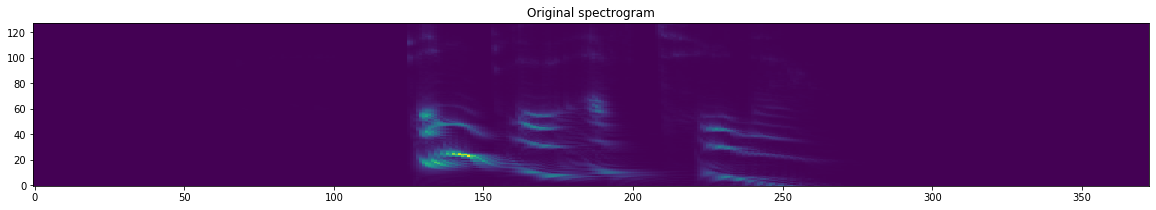

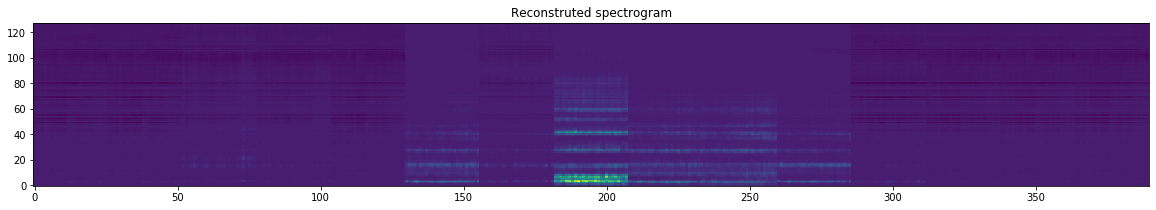

In [15]:
#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s1_000.mat')
original_data= original_data['y']
#print(original_data_shape)

# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)

  
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)

In [16]:
autoencoder=load_model('s16_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s16_autoencoder_weights.h5')

(390, 128)
(390, 128)


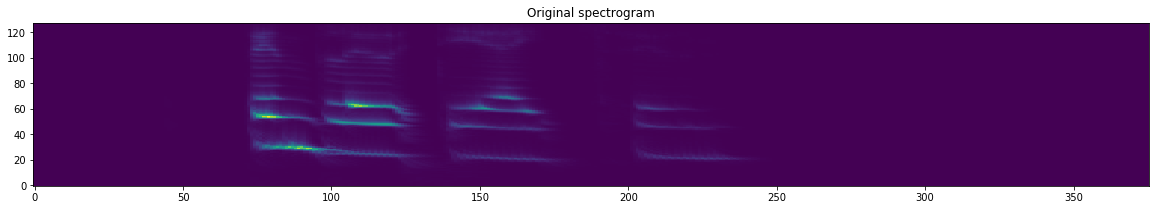

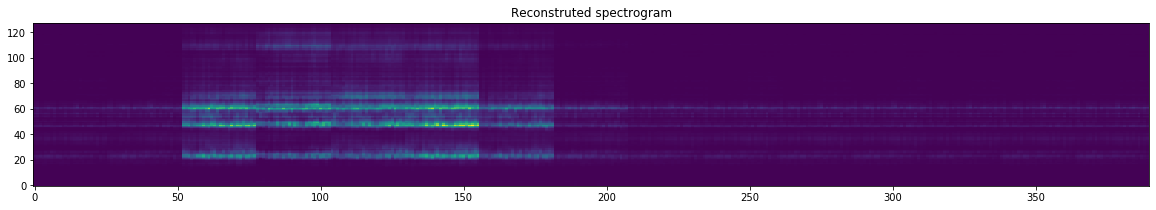

In [17]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s16/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part2.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)

model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T

#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s16_001.mat')
original_data= original_data['y']
#print(original_data_shape)

# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
 
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)


In [18]:
autoencoder=load_model('s25_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s25_autoencoder_weights.h5')

(390, 128)
(390, 128)


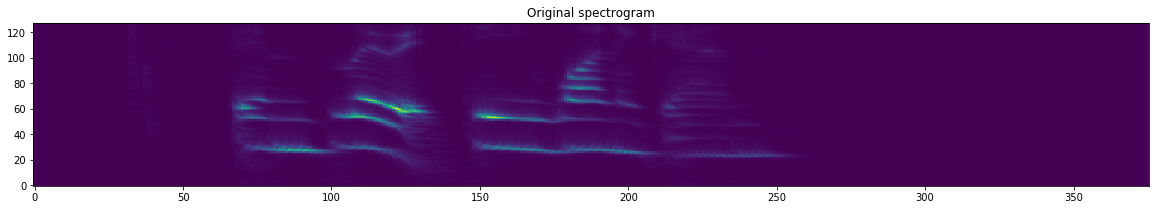

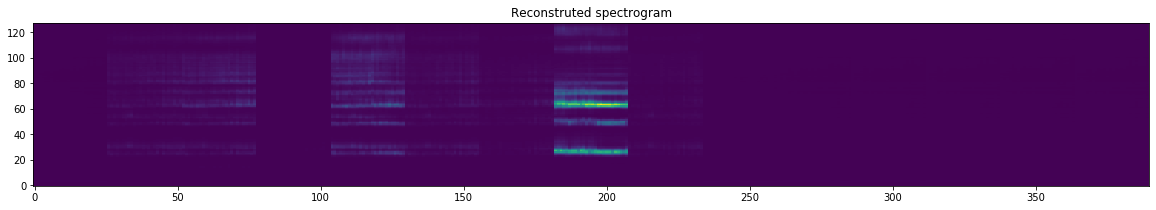

In [19]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s25/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part3.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)

model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T

#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s25_002.mat')
original_data= original_data['y']
#print(original_data_shape)

# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
 
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)

In [20]:
autoencoder=load_model('s27_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s27_autoencoder_weights.h5')

(390, 128)
(390, 128)


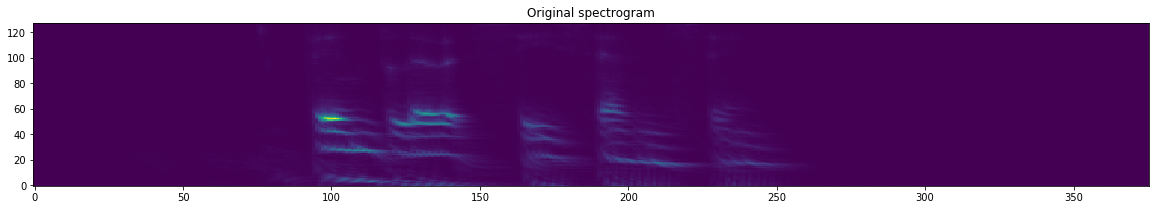

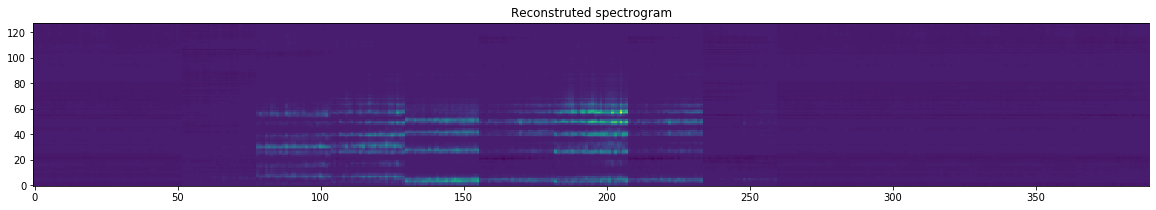

In [21]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s27/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part2.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)

model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T

#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s27_001.mat')
original_data= original_data['y']
#print(original_data_shape)

# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
 
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)

In [22]:
autoencoder=load_model('s17_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s17_autoencoder_weights.h5')

(390, 128)
(390, 128)


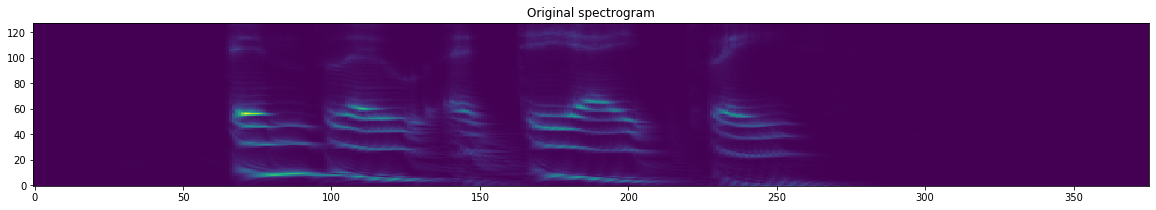

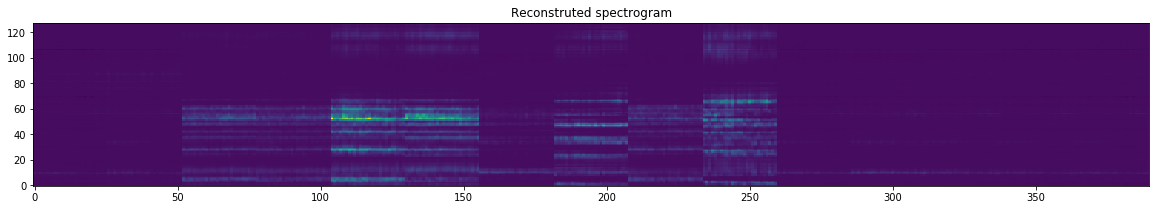

In [23]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s17/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part3.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)

model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T

#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s17_002.mat')
original_data= original_data['y']
#print(original_data_shape)

# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
 
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)

In [24]:
autoencoder=load_model('s15_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s15_autoencoder_weights.h5')

(390, 128)
(390, 128)


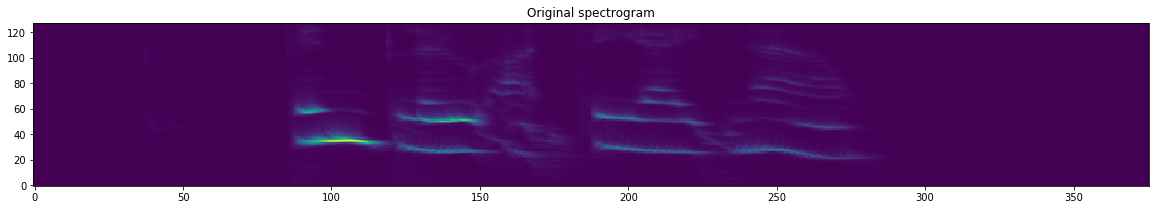

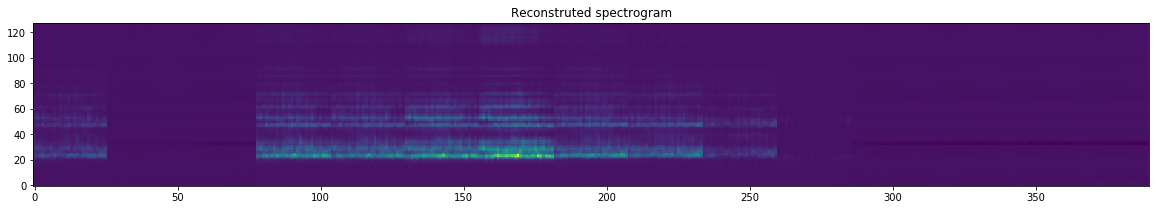

In [25]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s15/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part1.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)

model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T

#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s15_000.mat')
original_data= original_data['y']
#print(original_data_shape)

# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
 
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)

In [26]:
autoencoder=load_model('s10_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s10_autoencoder_weights.h5')

(15, 832)
(15, 32, 26)
(390, 32)
(390, 128)
(390, 128)


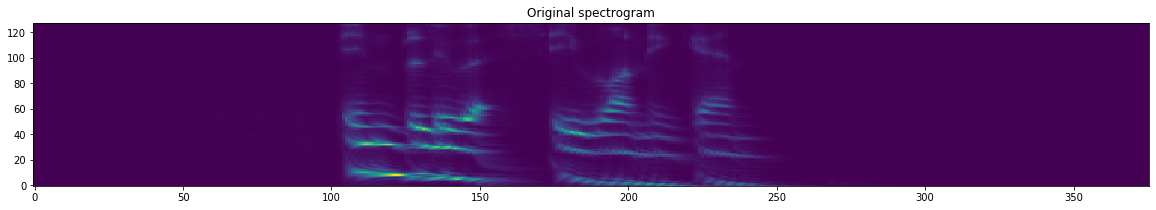

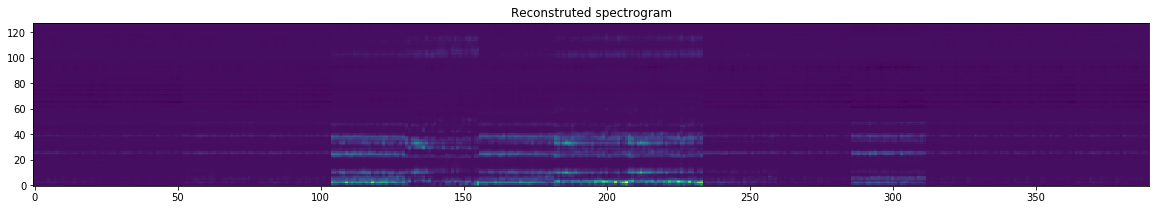

In [27]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s10/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part3.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)
print(model_output.shape)
model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T
print(model_output_reshape1.shape)
print(model_output_final.shape)



#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s10_002.mat')
original_data= original_data['y']
#print(original_data_shape)


# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
    
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)

In [28]:
autoencoder=load_model('s11_autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
autoencoder.load_weights('s11_autoencoder_weights.h5')

(15, 832)
(15, 32, 26)
(390, 32)
(390, 128)
(390, 128)


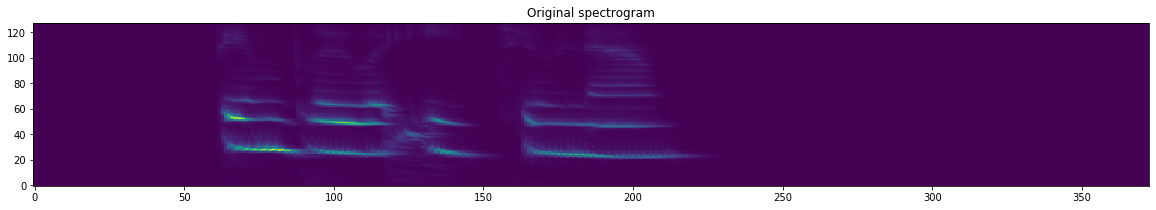

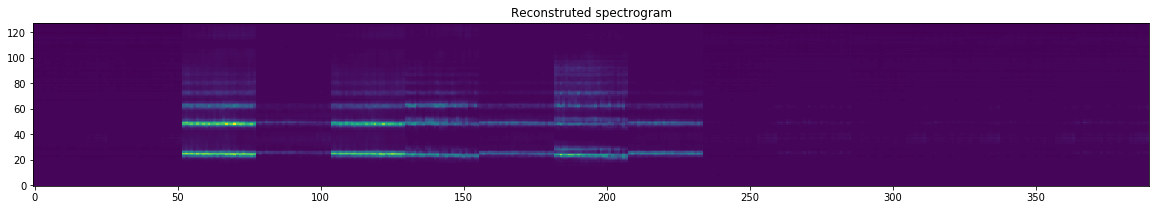

In [29]:
data_input = 'C:/Users/Andrew/sally_file/newTest/model_input/CNN_100/s11/'
mat1=sio.loadmat(data_input+'preprocessed_data_final_part1.mat')
video_input = mat1['video_input']
audio_input = mat1['audio_input']
model_output = model.predict(video_input)
print(model_output.shape)
model_output_reshape1=np.reshape(model_output,(audio_input.shape[0],audio_input.shape[1],audio_input.shape[2]))
model_output__reshape2=np.concatenate(model_output_reshape1,axis=1)
model_output_final = model_output__reshape2.T
print(model_output_reshape1.shape)
print(model_output_final.shape)



#orig_data_path='C:/Users/sally/Desktop/MRes_backup/data_set/gabor_features/s1_please/audio/AudSpecs/000.mat'
original_data=sio.loadmat('s11_000.mat')
original_data= original_data['y']
#print(original_data_shape)


# Plot Original spectrogram
figure1 = plt.figure(1,figsize=(20, 3))
plt.imshow(original_data.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Original spectrogram')
figure1.savefig(model_ouput+'Original spectrogram.png', dpi=figure1.dpi)
    
decoder_output =get_activations(autoencoder, 13, 19, model_output_final)[0]
print(decoder_output.shape)
final_model_output = np.power(decoder_output,3)
print(final_model_output.shape)
sio.savemat('final_model_output.mat', mdict={'final_model_output': final_model_output})
    
# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(20, 3))
plt.imshow(final_model_output.T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstruted spectrogram')
figure2.savefig(model_ouput+'Reconstruted spectrogram.png', dpi=figure1.dpi)